In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.linalg import expm, logm

In [4]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [5]:
print(data_odor['trialInfo'].shape)

(245, 4)


### Select LFP data for the same odor

In [67]:
trial_info = data_odor['trialInfo']
select = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)

In [68]:
print(np.sum(select))

58


In [69]:
lfp_odor = data_odor['lfpEpoch'][select, 2000:4000, :]

In [70]:
print(lfp_odor.shape)

(58, 2000, 21)


### Sliding window correlation and logarithm

In [71]:
corr_series = np.zeros((40, 100, 5, 5))
upper_series = np.zeros((40, 100, 15))
for i in range(40):
    for t in range(100):
        lfp_window = lfp_odor[i, (t * 10):(t * 10 + 100), 5:10]
        corr = np.corrcoef(lfp_window, rowvar=False)
        #corr = np.cov(lfp_window, rowvar=False)
        corr_series[i, t, :, :] = corr
        upper = logm(corr)[np.triu_indices(5)]
        upper_series[i, t, :] = upper

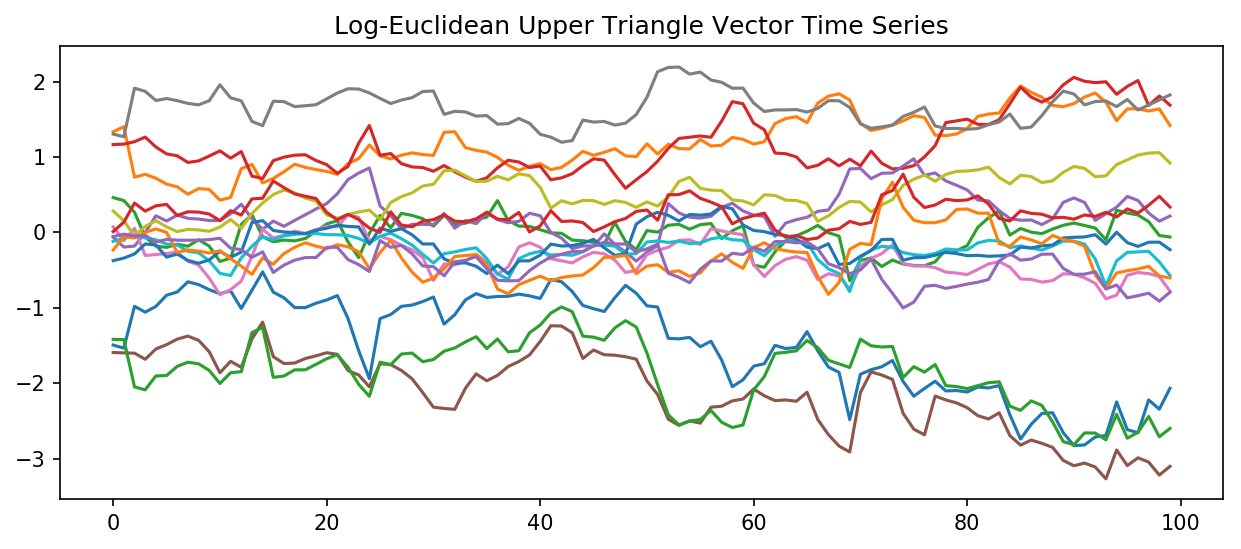

In [72]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for j in range(15):
    plt.plot(upper_series[0, :, j])
plt.title('Log-Euclidean Upper Triangle Vector Time Series')
plt.show()

In [73]:
select = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 2)

In [74]:
print(np.sum(select))

41


In [75]:
lfp_odor1 = data_odor['lfpEpoch'][select, 2000:4000, :]

In [76]:
corr_series1 = np.zeros((35, 100, 5, 5))
upper_series1 = np.zeros((35, 100, 15))
for i in range(35):
    for t in range(100):
        lfp_window = lfp_odor1[i, (t * 10):(t * 10 + 100), 5:10]
        corr = np.corrcoef(lfp_window, rowvar=False)
        #corr = np.cov(lfp_window, rowvar=False)
        corr_series1[i, t, :, :] = corr
        upper = logm(corr)[np.triu_indices(5)]
        upper_series1[i, t, :] = upper

In [77]:
all_upper = np.concatenate([upper_series, upper_series1])
print(all_upper.shape)

(75, 100, 15)


### Dimensionality reduction with PCA

In [78]:
from sklearn.decomposition import PCA

In [79]:
pca = PCA(n_components=5)
all_upper = all_upper.reshape((7500, 15))
#print(all_upper.shape)
pca.fit(all_upper)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [80]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.42108099 0.1408735  0.076668   0.07060714 0.06116813]
0.7703977507643117


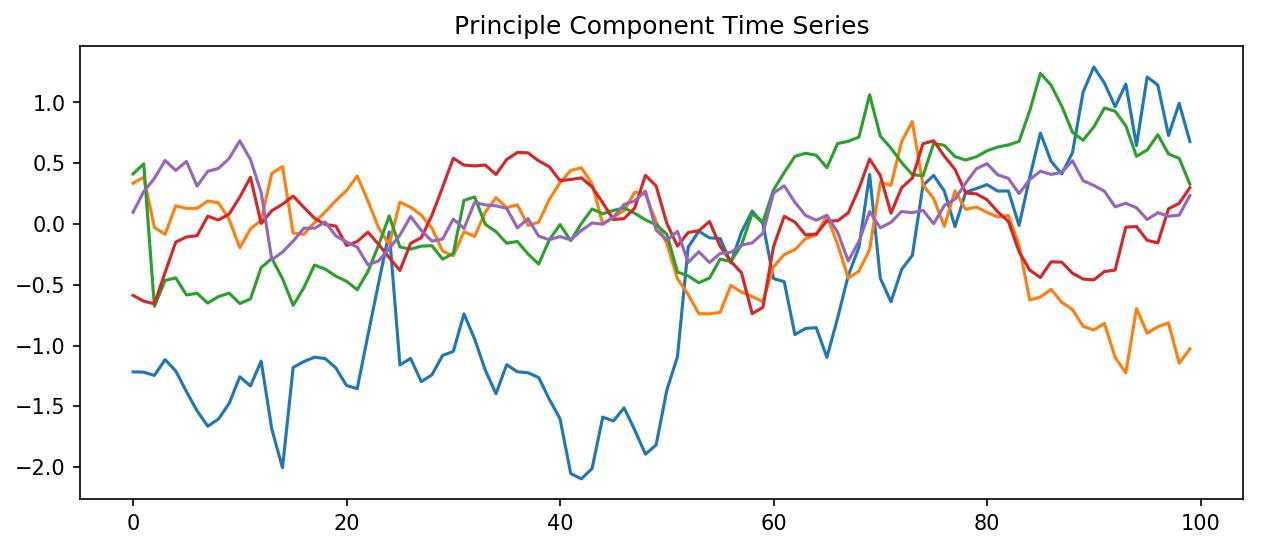

In [81]:
current_upper = upper_series[0, :, :]
comp_series = pca.transform(current_upper)
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(comp_series[:, 0])
plt.plot(comp_series[:, 1])
plt.plot(comp_series[:, 2])
plt.plot(comp_series[:, 3])
plt.plot(comp_series[:, 4])
plt.title('Principle Component Time Series')
plt.show()

### Compare with standard time series model

In [82]:
from statsmodels.tsa.ar_model import AR

In [83]:
y_true = comp_series[:, 4]
y_train = y_true[:90]
model = AR(y_train)
model = model.fit(maxlag=10)

In [84]:
ar_pred = model.predict(start=90, end=99)

In [85]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

In [86]:
kernel = Matern(length_scale=0.05, length_scale_bounds=(0.01, 0.5), nu=1.5) \
+ WhiteKernel(noise_level=0.1, noise_level_bounds=(0.001, 1.0))
X_train = np.linspace(0, 0.9, 90).reshape((90, 1))
posterior_mean = np.zeros((100, 5))
model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
posterior_mean = model.predict(np.linspace(0, 1, 100).reshape((100, 1)))

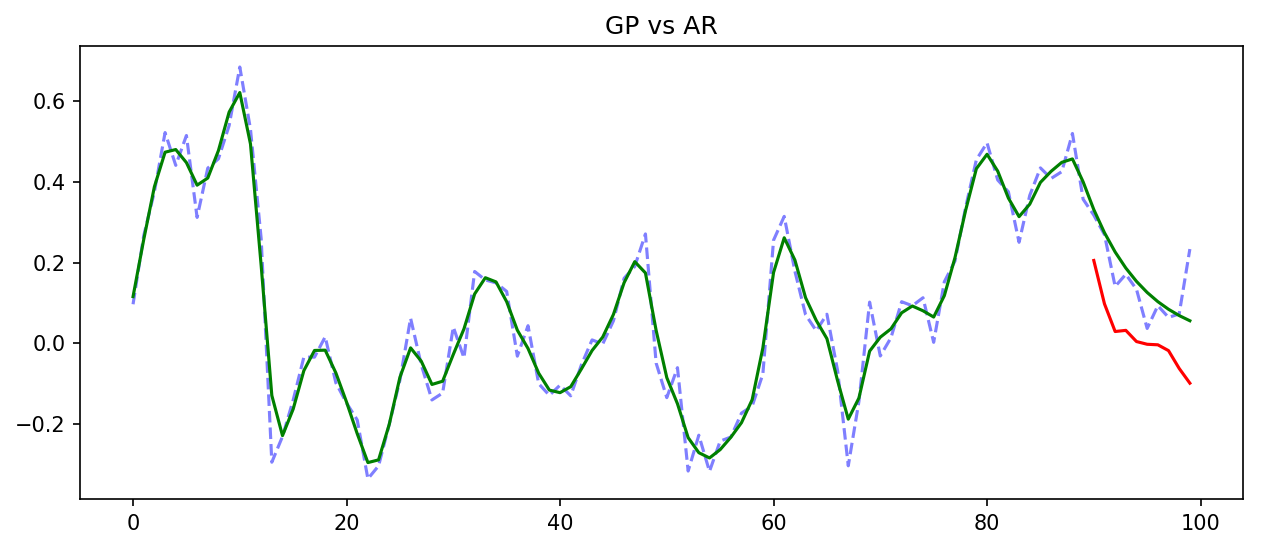

In [87]:
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(y_true, '--', alpha=0.5, color='blue')
plt.plot(posterior_mean, color='green')
plt.plot(np.arange(90, 100), ar_pred, color='red')
plt.title('GP vs AR')
plt.show()

### Gaussian process model with Matern kernel

In [88]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

In [89]:
kernel = Matern(length_scale=0.05, length_scale_bounds=(0.01, 0.5), nu=1.5) \
+ WhiteKernel(noise_level=0.1, noise_level_bounds=(0.001, 1.0))
model_list = []
X_train = np.linspace(0, 1, 100).reshape((100, 1))
posterior_mean = np.zeros((100, 5))
posterior_std = np.zeros((100, 5))
for j in range(5):
    y_train = comp_series[:, j]
    model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
    print(model.kernel_)
    model_list.append(model)
    current_mean, current_std = model.predict(X_train, return_std=True)
    posterior_mean[:, j] = current_mean
    posterior_std[:, j] = current_std

Matern(length_scale=0.0604, nu=1.5) + WhiteKernel(noise_level=0.0252)
Matern(length_scale=0.0816, nu=1.5) + WhiteKernel(noise_level=0.00906)
Matern(length_scale=0.123, nu=1.5) + WhiteKernel(noise_level=0.0135)
Matern(length_scale=0.0803, nu=1.5) + WhiteKernel(noise_level=0.0023)
Matern(length_scale=0.12, nu=1.5) + WhiteKernel(noise_level=0.00406)


In [90]:
def fit_gp(comp_series):
    kernel = Matern(length_scale=0.05, length_scale_bounds=(0.01, 0.5), nu=1.5) \
    + WhiteKernel(noise_level=0.1, noise_level_bounds=(0.001, 1.0))
    #model_list = []
    X_train = np.linspace(0, 1, 100).reshape((100, 1))
    length = np.zeros(5)
    noise = np.zeros(5)
    posterior_mean = np.zeros((100, 5))
    posterior_std = np.zeros((100, 5))
    for j in range(5):
        y_train = comp_series[:, j]
        model = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)
        length[j] = np.exp(model.kernel_.k1.theta)[0]
        noise[j] = np.exp(model.kernel_.k2.theta)[0]
        #model_list.append(model)
        current_mean, current_std = model.predict(X_train, return_std=True)
        posterior_mean[:, j] = current_mean
        posterior_std[:, j] = current_std
    return length, noise, posterior_mean, posterior_std

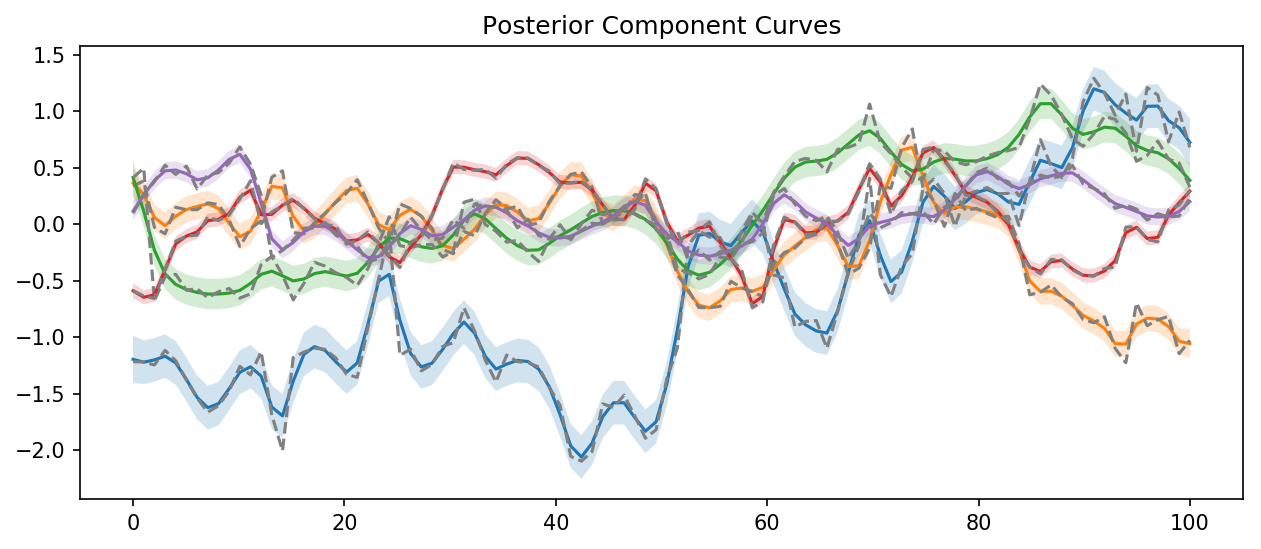

In [91]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
for j in range(5):
    plt.plot(np.linspace(0, 100, 100), posterior_mean[:, j])
    ax.fill_between(np.linspace(0, 100, 100), posterior_mean[:, j] - posterior_std[:, j], 
                    posterior_mean[:, j] + posterior_std[:, j], alpha=0.2)
    plt.plot(np.linspace(0, 100, 100), comp_series[:, j], '--', color='gray')
plt.title('Posterior Component Curves')
plt.show()

In [92]:
def create_symmetric_matrix(upper):
    mat = np.zeros((5, 5))
    mat[0, :] = upper[:5]
    mat[1, 1:] = upper[5:9]
    mat[2, 2:] = upper[9:12]
    mat[3, 3:] = upper[12:14]
    mat[4, 4] = upper[14]
    for i in range(1, 5):
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [93]:
upper_hat = pca.inverse_transform(posterior_mean)
print(upper_hat.shape)

(100, 15)


In [94]:
print(upper_series[0, 0, :])
print(upper_hat[0, :])

[-1.49491382  1.33317484  0.46097662  1.16407609 -0.06287764 -1.59376392
  0.07160893  1.30338632  0.28415035 -0.11863508 -0.3751102  -0.23302832
 -1.4189521   0.01057824 -0.05507958]
[-1.44483631  1.32927514  0.26431878  1.16738665  0.23888416 -1.65737042
 -0.25007808  1.42747258  0.13636124 -0.02349936  0.05133955 -0.07978304
 -1.50231884  0.01857655  0.13010994]


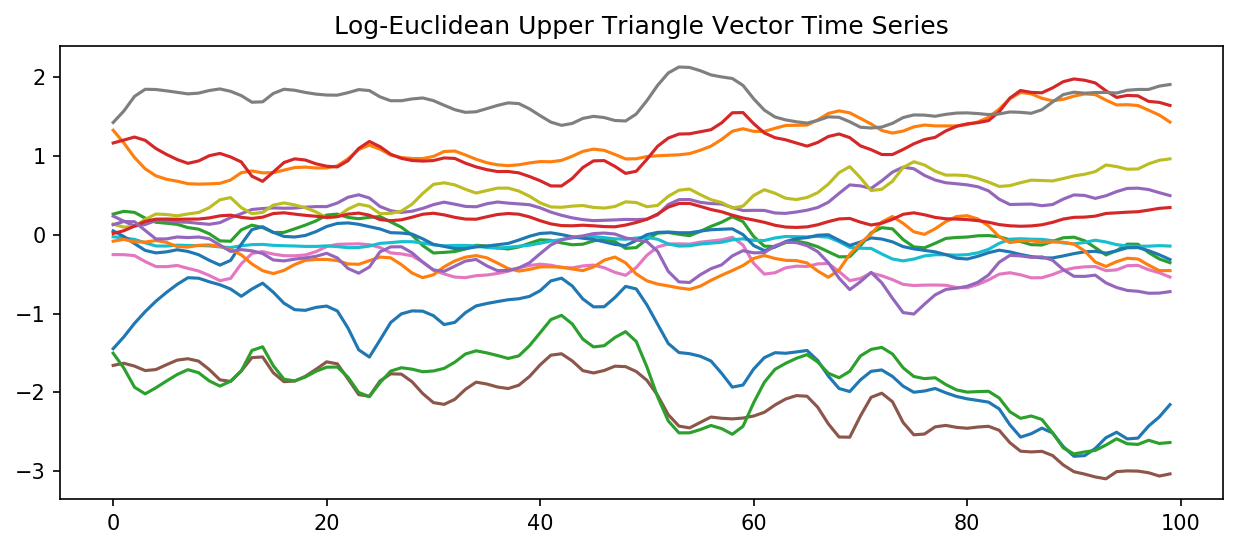

In [95]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for j in range(15):
    plt.plot(upper_hat[:, j])
plt.title('Log-Euclidean Upper Triangle Vector Time Series')
plt.show()

In [96]:
corr_hat = np.zeros((100, 5, 5))
for i in range(100):
    corr_hat[i, :, :] = expm(create_symmetric_matrix(upper_hat[i, :]))

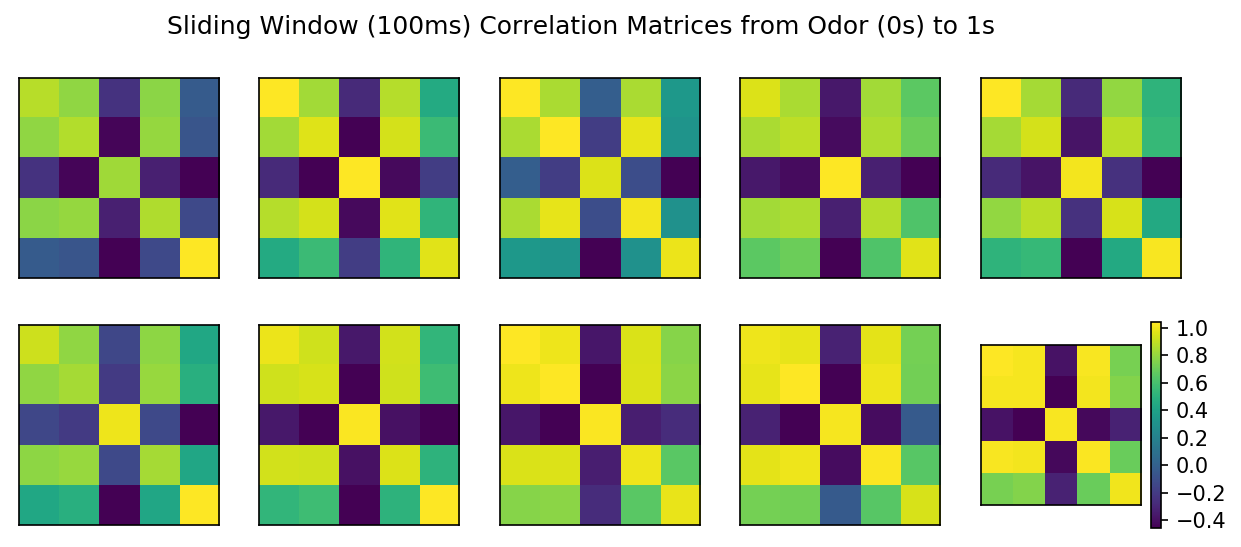

In [97]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(corr_hat[i * 10])
    plt.xticks([])
    plt.yticks([])
plt.colorbar()
plt.suptitle('Sliding Window (100ms) Correlation Matrices from Odor (0s) to 1s')
plt.show()

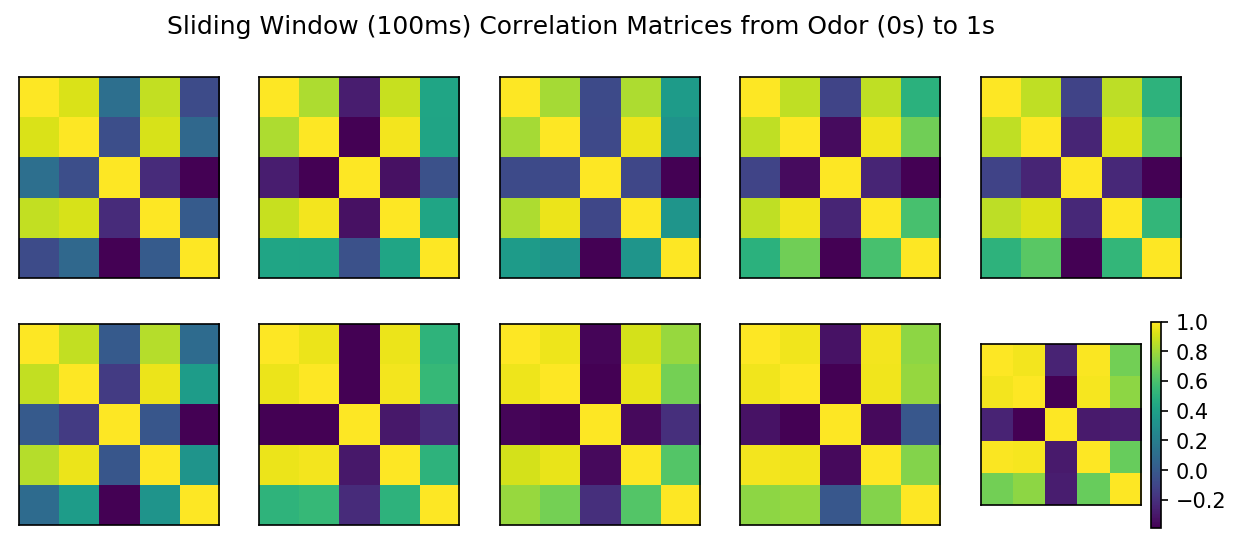

In [98]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(corr_series[0, i * 10, :, :])
    plt.xticks([])
    plt.yticks([])
plt.colorbar()
plt.suptitle('Sliding Window (100ms) Correlation Matrices from Odor (0s) to 1s')
plt.show()

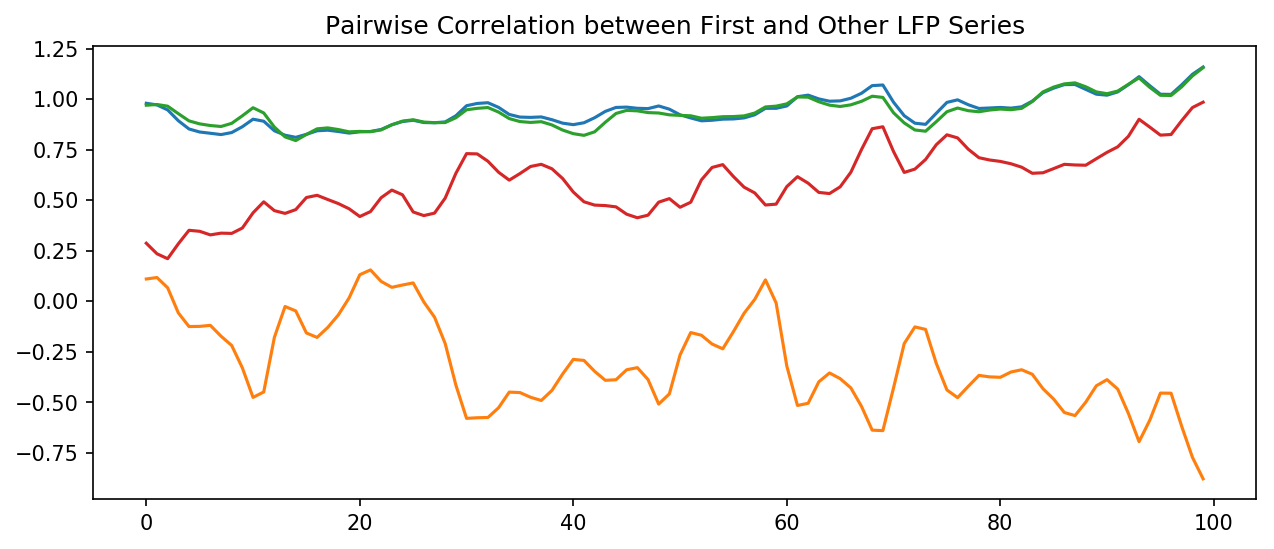

In [99]:
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(corr_hat[:, 0, 1])
plt.plot(corr_hat[:, 0, 2])
plt.plot(corr_hat[:, 0, 3])
plt.plot(corr_hat[:, 0, 4])
plt.title('Pairwise Correlation between First and Other LFP Series')
plt.show()

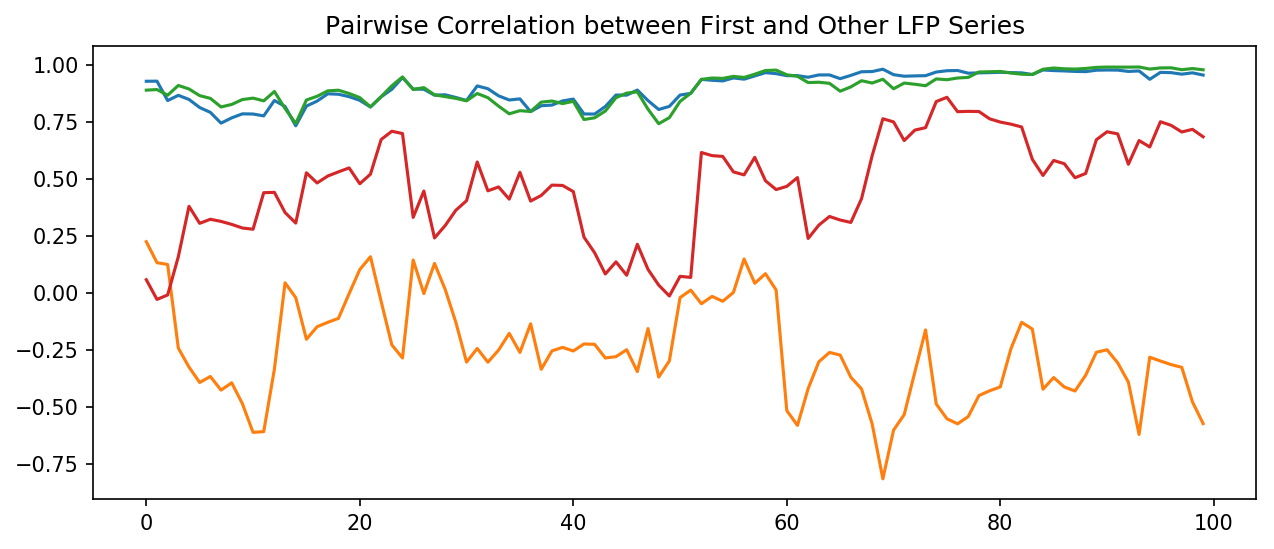

In [100]:
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(corr_series[0, :, 0, 1])
plt.plot(corr_series[0, :, 0, 2])
plt.plot(corr_series[0, :, 0, 3])
plt.plot(corr_series[0, :, 0, 4])
plt.title('Pairwise Correlation between First and Other LFP Series')
plt.show()

### Fit all the data for the same odor

In [101]:
all_length = np.zeros((40, 5))
all_noise = np.zeros((40, 5))
all_posterior = np.zeros((40, 100, 5))
for i in range(40):
    current_upper = upper_series[i, :, :]
    comp_series = pca.transform(current_upper)
    length, noise, posterior_mean, posterior_std = fit_gp(comp_series)
    all_length[i, :] = length
    all_noise[i, :] = noise
    all_posterior[i, :, :] = posterior_mean

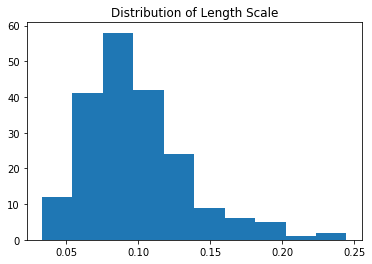

In [125]:
plt.hist(all_length.flatten())
plt.title('Distribution of Length Scale')
plt.show()

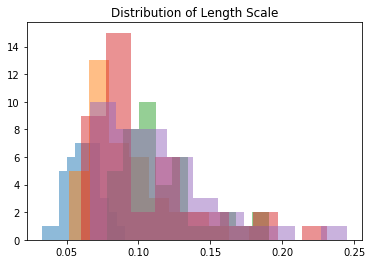

In [129]:
for j in range(5):
    plt.hist(all_length[:, j], alpha=0.5)
plt.title('Distribution of Length Scale')
plt.show()

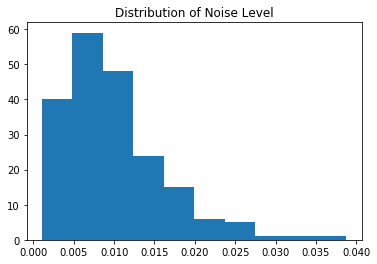

In [103]:
plt.hist(all_noise.flatten())
plt.title('Distribution of Noise Level')
plt.show()

In [104]:
print(upper_series.shape)
print(all_posterior.shape)

(40, 100, 15)
(40, 100, 5)


In [105]:
upper_hat = np.zeros((40, 100, 15))
for i in range(40):
    upper_hat[i, :, :] = pca.inverse_transform(all_posterior[i, :, :])

In [106]:
all_mse = np.mean(np.mean((upper_series - upper_hat) ** 2, axis=1), axis=1)
print(all_mse.shape)

(40,)


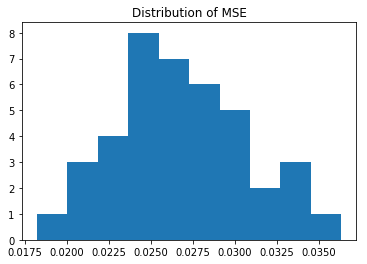

In [107]:
plt.hist(all_mse)
plt.title('Distribution of MSE')
plt.show()

In [108]:
print(upper_hat.shape)

(40, 100, 15)


### Group posterior mean

In [109]:
upper_odor = np.mean(upper_hat, axis=0)
corr_odor = np.zeros((100, 5, 5))
for i in range(100):
    corr_odor[i, :, :] = expm(create_symmetric_matrix(upper_odor[i, :]))

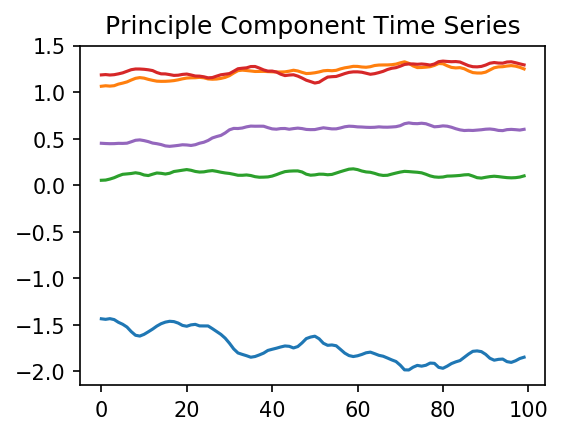

In [110]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(upper_odor[:, 0])
plt.plot(upper_odor[:, 1])
plt.plot(upper_odor[:, 2])
plt.plot(upper_odor[:, 3])
plt.plot(upper_odor[:, 4])
plt.title('Principle Component Time Series')
plt.show()

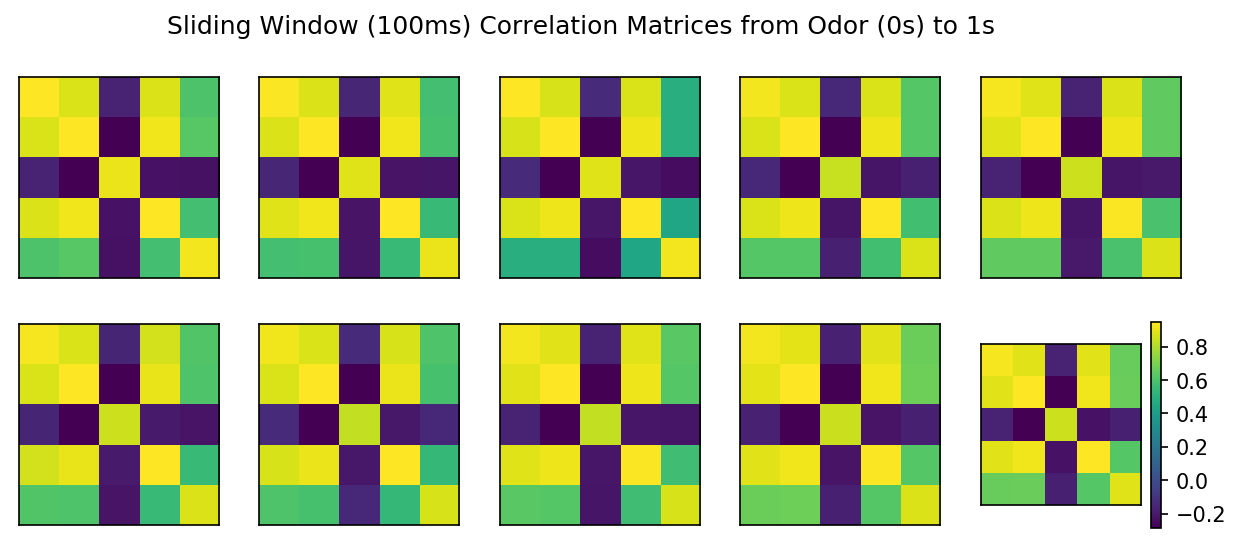

In [111]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(corr_odor[i * 10])
    plt.xticks([])
    plt.yticks([])
plt.colorbar()
plt.suptitle('Sliding Window (100ms) Correlation Matrices from Odor (0s) to 1s')
plt.show()

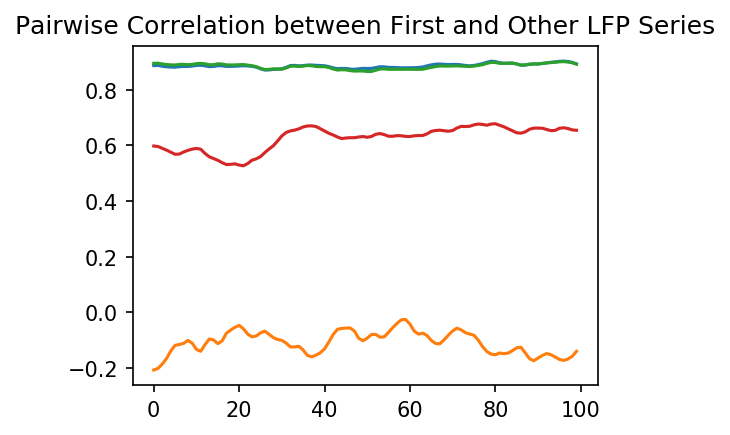

In [112]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(corr_odor[:, 0, 1])
plt.plot(corr_odor[:, 0, 2])
plt.plot(corr_odor[:, 0, 3])
plt.plot(corr_odor[:, 0, 4])
plt.title('Pairwise Correlation between First and Other LFP Series')
plt.show()

### Repeat the same analysis for a different odor

In [113]:
all_length1 = np.zeros((35, 5))
all_noise1 = np.zeros((35, 5))
all_posterior1 = np.zeros((35, 100, 5))
for i in range(35):
    current_upper = upper_series1[i, :, :]
    comp_series = pca.transform(current_upper)
    length, noise, posterior_mean, posterior_std = fit_gp(comp_series)
    all_length1[i, :] = length
    all_noise1[i, :] = noise
    all_posterior1[i, :, :] = posterior_mean

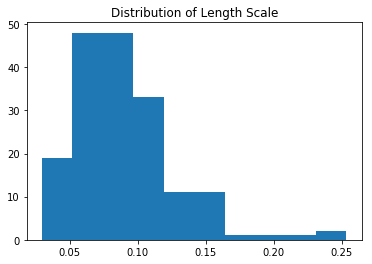

In [114]:
plt.hist(all_length1.flatten())
plt.title('Distribution of Length Scale')
plt.show()

In [115]:
upper_hat1 = np.zeros((35, 100, 15))
for i in range(35):
    upper_hat1[i, :, :] = pca.inverse_transform(all_posterior1[i, :, :])

In [116]:
all_mse1 = np.mean(np.mean((upper_series1 - upper_hat1) ** 2, axis=1), axis=1)
print(all_mse1.shape)

(35,)


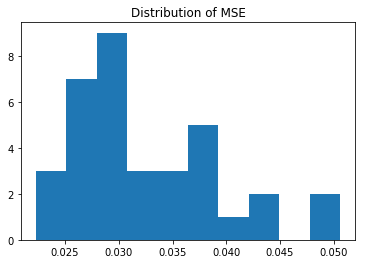

In [117]:
plt.hist(all_mse1)
plt.title('Distribution of MSE')
plt.show()

In [118]:
upper_odor1 = np.mean(upper_hat1, axis=0)
corr_odor1 = np.zeros((100, 5, 5))
for i in range(100):
    corr_odor1[i, :, :] = expm(create_symmetric_matrix(upper_odor1[i, :]))

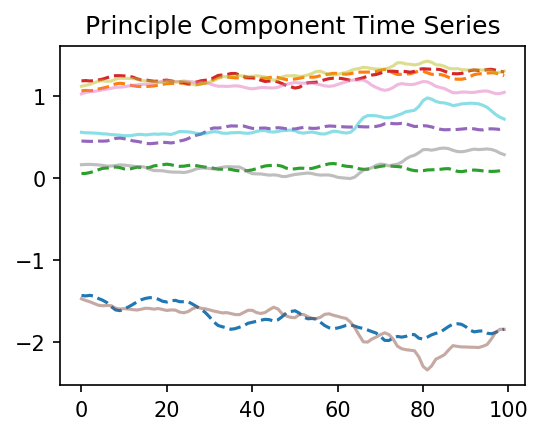

In [121]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(upper_odor[:, 0], '--')
plt.plot(upper_odor[:, 1], '--')
plt.plot(upper_odor[:, 2], '--')
plt.plot(upper_odor[:, 3], '--')
plt.plot(upper_odor[:, 4], '--')
plt.plot(upper_odor1[:, 0], alpha=0.5)
plt.plot(upper_odor1[:, 1], alpha=0.5)
plt.plot(upper_odor1[:, 2], alpha=0.5)
plt.plot(upper_odor1[:, 3], alpha=0.5)
plt.plot(upper_odor1[:, 4], alpha=0.5)
plt.title('Principle Component Time Series')
plt.show()

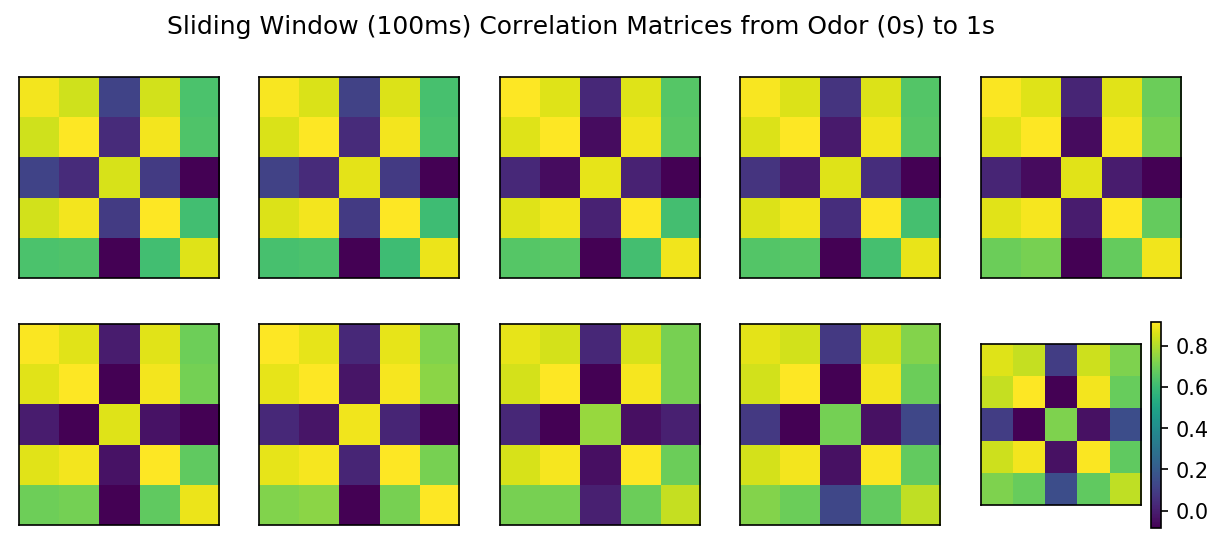

In [122]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(corr_odor1[i * 10])
    plt.xticks([])
    plt.yticks([])
plt.colorbar()
plt.suptitle('Sliding Window (100ms) Correlation Matrices from Odor (0s) to 1s')
plt.show()

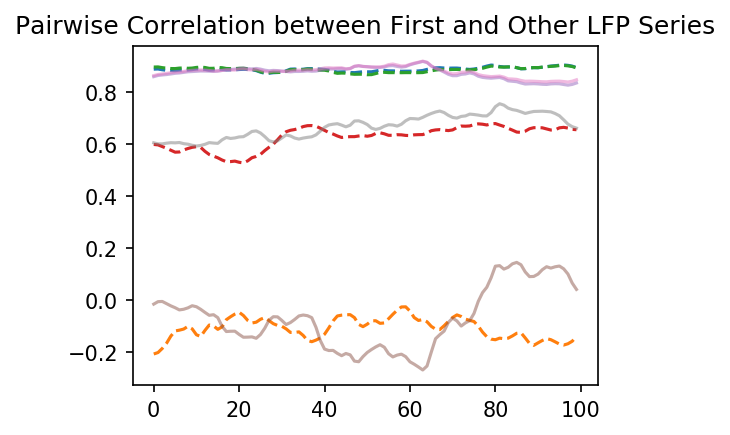

In [124]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(corr_odor[:, 0, 1], '--')
plt.plot(corr_odor[:, 0, 2], '--')
plt.plot(corr_odor[:, 0, 3], '--')
plt.plot(corr_odor[:, 0, 4], '--')
plt.plot(corr_odor1[:, 0, 1], alpha=0.5)
plt.plot(corr_odor1[:, 0, 2], alpha=0.5)
plt.plot(corr_odor1[:, 0, 3], alpha=0.5)
plt.plot(corr_odor1[:, 0, 4], alpha=0.5)
plt.title('Pairwise Correlation between First and Other LFP Series')
plt.show()

In [ ]:
print(data_odor['lfpEpoch'].shape)

In [ ]:
lfp_trial = data_odor['lfpEpoch'][0, 2000:4000, :]

In [ ]:
print(lfp_trial.shape)

In [ ]:
lfp_window = lfp_trial[100:200, 5:10]

In [ ]:
corr = np.corrcoef(lfp_window, rowvar=False)

In [ ]:
plt.imshow(corr)
plt.colorbar()
plt.show()

In [ ]:
upper = logm(corr)[np.triu_indices(5)]
print(upper)

In [ ]:
print(corr.shape)

In [ ]:
print(corr)

In [ ]:
print(upper.shape)

In [ ]:
upper_series = np.zeros((100, 15))
corr_series = np.zeros((100, 5, 5))
for i in range(100):
    lfp_window = lfp_trial[(i * 10):(i * 10 + 100), 5:10]
    corr = np.corrcoef(lfp_window, rowvar=False)
    corr_series[i, :, :] = corr
    upper = logm(corr)[np.triu_indices(5)]
    upper_series[i, :] = upper

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(corr_series[i * 10])
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Sliding Window (100ms) Correlation Matrices from Odor (0s) to 1s')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(corr_series[:, 0, 1])
plt.plot(corr_series[:, 0, 2])
plt.plot(corr_series[:, 0, 3])
plt.plot(corr_series[:, 0, 4])
plt.title('Pairwise Correlation between First and Other LFP Series')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
for j in range(15):
    plt.plot(upper_series[:, j])
plt.title('Log-Euclidean Upper Triangle Vector Time Series')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=4)
comp_series = pca.fit_transform(upper_series)

In [ ]:
print(comp_series.shape)

In [ ]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=150)
plt.plot(comp_series[:, 0])
plt.plot(comp_series[:, 1])
plt.plot(comp_series[:, 2])
plt.plot(comp_series[:, 3])
plt.title('Principle Component Time Series')
plt.show()